In [3]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("device", device)

def log_act(a):
    out = torch.where(a > 0, torch.log(a + 1), -torch.log(-a + 1))
    return out

device cuda


In [4]:

hidden_size = 256
input_size = 10
output_size = 1


In [45]:
class BnnLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.tanh = nn.Tanh()
        self.relu = nn.LeakyReLU(0.1)

        self.w1 = nn.Parameter(
            torch.zeros(self.input_size, self.hidden_size, dtype = torch.float32, requires_grad=True)
        )
        self.b1 = nn.Parameter(
            torch.zeros(self.hidden_size, dtype = torch.float32,requires_grad=True)
        )
        self.w2 = nn.Parameter(
            torch.zeros(self.hidden_size, self.hidden_size, dtype = torch.float32, requires_grad=True)
        )
        self.b2 = nn.Parameter(
            torch.zeros(self.hidden_size, dtype = torch.float32, requires_grad=True)
        )
        self.w3 = nn.Parameter(
            torch.zeros(self.hidden_size, self.output_size, dtype = torch.float32, requires_grad=True)
        )
        self.b3 = nn.Parameter(
            torch.zeros(self.hidden_size, dtype = torch.float32, requires_grad=True)
        )
        self.w4 = nn.Parameter(
            torch.zeros(self.hidden_size, self.output_size, dtype = torch.float32, requires_grad=True)
        )

        torch.nn.init.uniform_(self.w1, -0.02, 0.02)
        torch.nn.init.uniform_(self.w2, -0.02, 0.02)
        torch.nn.init.uniform_(self.w3, -0.02, 0.02)
        torch.nn.init.uniform_(self.w4, -0.02, 0.02)
        torch.nn.init.uniform_(self.b1, -0.02, 0.02)
        torch.nn.init.uniform_(self.b2, -0.02, 0.02)
        torch.nn.init.uniform_(self.b3, -0.02, 0.02)

    def rep(self, mu):
        return mu + torch.randn_like(mu)*0.01

    def forward(self, x):
        b1 = self.rep(self.b1)
        b2 = self.rep(self.b2)
        b3 = self.rep(self.b3)
        w1 = self.rep(self.w1)
        w2 = self.rep(self.w2)
        w3 = self.rep(self.w3)
        w4 = self.rep(self.w4)
        b1 = b1.unsqueeze(0)
        b2 = b2.unsqueeze(0)
        b3 = b3.unsqueeze(0)

        x = torch.matmul(x, w1) + b1

        x = self.relu(x)

        x = torch.matmul(x, w2) + b2

        x = self.relu(x)
        x = torch.matmul(x, w3)

        return x

    def kldloss(self):
        sum1 = torch.sum(torch.square(self.w1))
        sum2 = torch.sum(torch.square(self.w2))
        sum3 = torch.sum(torch.square(self.w3))

        sum5 = torch.sum(torch.square(self.b1))
        sum6 = torch.sum(torch.square(self.b2))

        return sum1 + sum2 + sum3 + sum5 + sum6


filtered_data torch.Size([30000, 3])
data torch.Size([37500, 3])


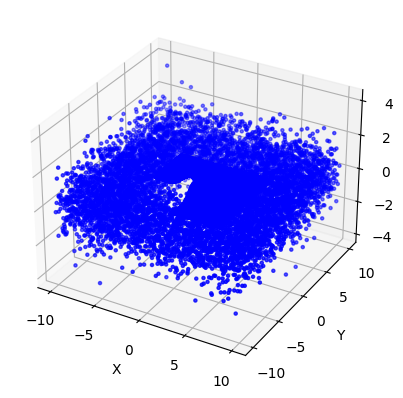

In [42]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate the dataset
x = torch.linspace(-5, 5, 200)
y = torch.linspace(-5, 5, 200)
X, Y = torch.meshgrid(x, y)
R = torch.sqrt(X**2 + Y**2)
Z = torch.exp(-R**2 / 5) * torch.sin(R)
# Convert data to float32
X, Y, Z = X.float(), Y.float(), Z.float()
# Flatten and stack the data
data = torch.stack((X.flatten(), Y.flatten(), Z.flatten()), dim=1)

# Remove data where X < 0 or Y < 0
mask = (data[:, 0] >= 0) | (data[:, 1] >= 0)
filtered_data = data[mask]
print("filtered_data", filtered_data.size())
x = torch.linspace(-10, 10, 100)
y = torch.linspace(-10, 10, 100)
X, Y = torch.meshgrid(x, y)
R = torch.sqrt(X + Y)
noise = torch.randn_like(R)

X, Y, noise = X.float(), Y.float(), noise.float()
data = torch.stack((X.flatten(), Y.flatten(), noise.flatten()), dim=1)
mask = (data[:, 0] <= -5) | (data[:, 1] <= -5) | ( data[:, 0] >= 5) | (data[:, 1] >= 5)
noise_data = data[mask]


data = torch.cat((filtered_data, noise_data), 0)
print("data", data.size())

# Split the filtered dataset into features and target
X_data = data[:, :2]
Y_data = data[:, 2:]

# Visualize the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_data[:, 0], X_data[:, 1], Y_data, c='b', marker='o', s=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()



In [46]:
mybnn = BnnLayer(2, 256, 1)
print(len(data))

37500


In [47]:
train_dataloader = DataLoader(data, batch_size=37500, shuffle=True)
optimizer = torch.optim.SGD(mybnn.parameters(), lr=0.000001)

i = 0
while i < 100000:
    train_data = next(iter(train_dataloader))
    newdata = torch.split(train_data, 2, dim = 1)
    #input = vae.encoder(newdata[0])
    output = mybnn(newdata[0])
    likelihood = torch.sum(torch.square(newdata[1].squeeze() - output.squeeze()))
    loss = likelihood + mybnn.kldloss()

    #print(likelihood)
    #print(mybnn.kldloss())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(likelihood)
    print("kld",mybnn.kldloss())
    if i%100 == 0:
      print(likelihood)
      print("kld",mybnn.kldloss())
    i = i + 1

tensor(9129.9336, grad_fn=<SumBackward0>)
kld tensor(8.8599, grad_fn=<AddBackward0>)
tensor(9129.9336, grad_fn=<SumBackward0>)
kld tensor(8.8599, grad_fn=<AddBackward0>)
tensor(9116.7861, grad_fn=<SumBackward0>)
kld tensor(8.8598, grad_fn=<AddBackward0>)
tensor(9103.0420, grad_fn=<SumBackward0>)
kld tensor(8.8597, grad_fn=<AddBackward0>)
tensor(9099.8262, grad_fn=<SumBackward0>)
kld tensor(8.8596, grad_fn=<AddBackward0>)
tensor(9108.5508, grad_fn=<SumBackward0>)
kld tensor(8.8596, grad_fn=<AddBackward0>)
tensor(9095.1152, grad_fn=<SumBackward0>)
kld tensor(8.8595, grad_fn=<AddBackward0>)
tensor(9102.2998, grad_fn=<SumBackward0>)
kld tensor(8.8594, grad_fn=<AddBackward0>)
tensor(9098.9746, grad_fn=<SumBackward0>)
kld tensor(8.8594, grad_fn=<AddBackward0>)
tensor(9103.8984, grad_fn=<SumBackward0>)
kld tensor(8.8593, grad_fn=<AddBackward0>)
tensor(9117.7363, grad_fn=<SumBackward0>)
kld tensor(8.8593, grad_fn=<AddBackward0>)
tensor(9101.6211, grad_fn=<SumBackward0>)
kld tensor(8.8592, grad

KeyboardInterrupt: ignored

<ipython-input-48-6ff474f98060>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z9 = torch.tensor(z, requires_grad = False).numpy()


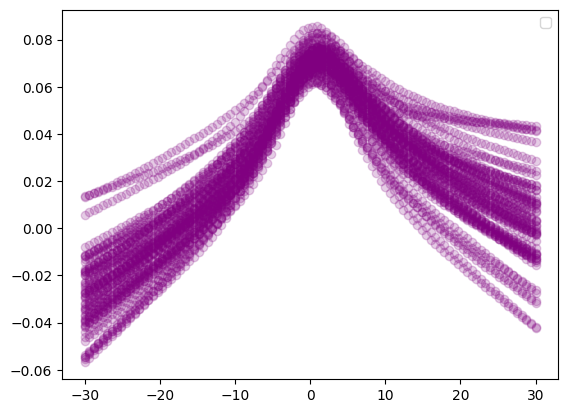

In [48]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-30, 30, 100)
y = np.linspace(3, 3, 100)
newxy = np.concatenate((np.transpose([x]), np.transpose([y])), axis = 1)
newxy = torch.tensor(newxy, dtype = torch.float32)
newxy = torch.reshape(newxy,(100,2))

i = 0
while i<50:
    #z = vae.encoder(newxy)
    z = mybnn(newxy)
    Z9 = torch.tensor(z, requires_grad = False).numpy()
    plt.scatter(x, Z9, color = 'purple', alpha = 0.2)
    i = i + 1

plt.legend()
plt.show()

torch.Size([20, 20])


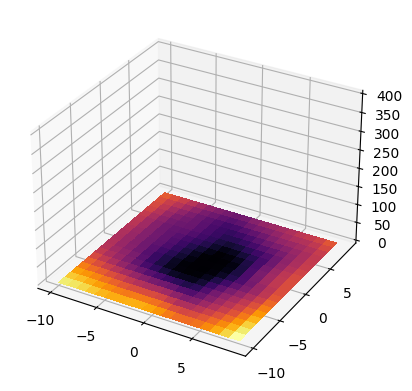

In [62]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-10, 10, 1)
Y = np.arange(-10, 10, 1)
X, Y = np.meshgrid(X, Y)
#print(np.shape(X))
#print(torch.tensor(X).unsqueeze(-1))
#print(np.shape(Y))
#print(Y)

newx = torch.tensor(X).unsqueeze(-1).type(torch.float32)
newy = torch.tensor(Y).unsqueeze(-1).type(torch.float32)
newxy = torch.cat((newx, newy), -1)
newxy = newxy.reshape(-1, 2)

#z = vae.encoder(newxy)
z = mybnn(newxy)
z = z.reshape(1, 20, 20)
Zstack = z


i = 0
while i<1000:
    #z = vae.encoder(newxy)
    z = mybnn(newxy)
    z = z.reshape(1, 20, 20)
    Zstack = torch.cat((Zstack, z), 0)
    i = i + 1

diff = torch.max(Zstack, 0)[0] - torch.min(Zstack, 0)[0]
print(diff.size())
# Plot the surface.
surf = ax.plot_surface(X, Y, diff.detach().numpy(), cmap='inferno',
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 400)
# ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.

plt.show()


In [ ]:
from torch import nn
import torch
from torch.utils.data import DataLoader

class VAE(nn.Module):
  def __init__(self, in_size, hidden, out_size):
        super(VAE, self).__init__()
        self.L1 = nn.Linear(2, 256)
        self.L2 = nn.Linear(256, 10)
        self.L3 = nn.Linear(10, 256)
        self.L4 = nn.Linear(256, 2)
        self.relu = nn.LeakyReLU(0.1)

  def rep(self, mu):
        return mu + torch.randn_like(mu)*0.1

  def encoder(self, x):
        x = self.L1(x)
        x = self.relu(x)
        output = self.L2(x)
        return output

  def decoder(self, x):
        x = self.L3(x)
        x = self.relu(x)
        output = self.L4(x)
        return output

  def forward(self, x):
        x = self.encoder(x)
        x = self.rep(x)
        x = self.decoder(x)
        return x


vae = VAE(2,256,10)


In [ ]:
tmp_data = torch.tensor([[-5, -12], [-5, 7], [-5, 9],
                         [-3, -10], [-3, 5], [-3, 8],
                         [-2, 2], [-1, 2], [-1, 3],
                         [-1, -4], [0, 1], [1, 10],
                         [2, -2], [3, 2], [4, 14],
                         [5, -4], [5, 5], [6, 4],
                         [7, -14], [8, 3], [8, 12],
                         [9, -6], [10, 12]], dtype=torch.float32)

In [ ]:
vae(tmp_data).size()

torch.Size([23, 2])

In [ ]:
optimizer = torch.optim.SGD(vae.parameters(), lr=0.00001)
train_dataloader = DataLoader(tmp_data, batch_size=23, shuffle=False)

In [ ]:
i = 0
while i < 10000:
    train_data = next(iter(train_dataloader))
    output = vae(train_data)
    likelihood = torch.sum(torch.square(output - train_data))
    loss = likelihood

    #print(likelihood)
    #print(mybnn.kldloss())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%1000 == 0:
      print(train_data)
      print(output)
    i = i + 1

tensor([[ -5., -12.],
        [ -5.,   7.],
        [ -5.,   9.],
        [ -3., -10.],
        [ -3.,   5.],
        [ -3.,   8.],
        [ -2.,   2.],
        [ -1.,   2.],
        [ -1.,   3.],
        [ -1.,  -4.],
        [  0.,   1.],
        [  1.,  10.],
        [  2.,  -2.],
        [  3.,   2.],
        [  4.,  14.],
        [  5.,  -4.],
        [  5.,   5.],
        [  6.,   4.],
        [  7., -14.],
        [  8.,   3.],
        [  8.,  12.],
        [  9.,  -6.],
        [ 10.,  12.]])
tensor([[ 3.4509e-01,  1.1242e+00],
        [ 6.0586e-01, -2.3765e-01],
        [ 7.0756e-01, -1.9054e-01],
        [ 2.6009e-01,  9.3956e-01],
        [ 3.8769e-01, -1.0261e-01],
        [ 5.9226e-01, -1.2063e-01],
        [ 1.6946e-01, -1.1103e-02],
        [ 7.6569e-02,  6.3273e-02],
        [ 1.9533e-01, -3.6685e-04],
        [ 1.5282e-01,  5.2849e-01],
        [ 5.3382e-02,  2.4774e-02],
        [ 7.2679e-01, -2.3461e-01],
        [ 1.2514e-01,  4.1624e-01],
        [ 8.0555e-02,  1.